#### **Construcción de un Modelo de Scoring de Comportamiento**

**Objetivo:** Crear un modelo que otorgue a cada cliente una puntuación para ordenar a los clientes de acuerdo con su calidad crediticia.


**Librerías**

In [1]:
import pandas as pd
from pyxlsb import open_workbook
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, chi2_contingency, norm
from pandas.api.types import is_numeric_dtype
from sklearn.feature_selection import mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings

### **1. Carga y Exploración de los Datos**

In [2]:
# Define la ruta al archivo .xlsb
file_path = './BBDD_Scoring.xlsb' 

# Inicializa una lista para almacenar los datos
data = []

# Lee el archivo y extrae las filas
with open_workbook(file_path) as wb:
    with wb.get_sheet(1) as sheet:
        for row in sheet.rows():
            data.append([item.v for item in row])

# Convierte los datos en un DataFrame
df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
# Muestra las primeras filas para verificar la carga
df.head()

,Cliente,default,Edad,Sal_BurCto_Year,Dias_impago_hip,Dias_impago_hip_year,Dias_mora_hip_year,Ant_hipotecaria,Importe_impago_hip,Importe_impago_hip_year,...,Importe_mora_year,Dias_impago_mes,Dias_impago_tri,Dias_impago_year,Dias_impago_2year,Dias_mora,Dias_mora_tri,Dias_mora_year,Dias_mora_2year,Cuotas_ptmos
0,1.0,0.0,70.42,0.0,0.0,0.0,0.0,102.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,2.0,0.0,44.28,0.0,0.0,0.0,0.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,425.81
2,3.0,0.0,46.70,0.0,0.0,0.0,0.0,162.0,0.0,0.0,...,0.0,0.0,3.0,5.0,6.0,0.0,0.0,0.0,0.0,377.76
3,4.0,0.0,68.19,0.0,0.0,0.0,0.0,159.0,0.0,0.0,...,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,853.85
4,5.0,0.0,55.43,0.0,0.0,0.0,0.0,188.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Se ha decidido **quitar las columnas que solo tienen un valor único**, ya que no aportan información al modelo.

In [4]:
# Calcular número de valores distintos en cada columna
columnas_sin_valores_distintos = df.nunique()[df.nunique() < 2].index
df = df.drop(columnas_sin_valores_distintos, axis=1)
df

,Cliente,default,Edad,Sal_BurCto_Year,Dias_impago_hip_year,Dias_mora_hip_year,Ant_hipotecaria,Importe_impago_hip_year,Dias_imp_ptmopres_Tri,Importe_impago_ptmopers_year,...,Importe_impagado_year,Importe_mora_tri,Importe_mora_year,Dias_impago_tri,Dias_impago_year,Dias_impago_2year,Dias_mora_tri,Dias_mora_year,Dias_mora_2year,Cuotas_ptmos
0,1.0,0.0,70.42,0.0,0.0,0.0,102.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,2.0,0.0,44.28,0.0,0.0,0.0,108.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,425.81
2,3.0,0.0,46.70,0.0,0.0,0.0,162.0,0.00,0.0,0.0,...,154.99,0.0,0.00,3.0,5.0,6.0,0.0,0.0,0.0,377.76
3,4.0,0.0,68.19,0.0,0.0,0.0,159.0,0.00,0.0,0.0,...,50.56,0.0,0.00,0.0,4.0,4.0,0.0,0.0,0.0,853.85
4,5.0,0.0,55.43,0.0,0.0,0.0,188.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249428,249429.0,1.0,37.69,0.0,35.0,0.0,35.0,2819.09,0.0,0.0,...,2819.09,0.0,21.03,0.0,91.0,91.0,0.0,20.0,20.0,0.00
249429,249430.0,1.0,52.48,0.0,0.0,0.0,15.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,232.28
249430,249431.0,1.0,51.50,0.0,0.0,0.0,15.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,689.01
249431,249432.0,1.0,36.41,0.0,0.0,0.0,13.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,92.33


In [5]:
# 1. Exploración Inicial

# Convertir a variables categóricas para su posterior análisis
df['Cliente'] = df['Cliente'].astype('object')
df['default'] = df['default'].astype('object')
df['Indicador_tarjeta'] = df['Indicador_tarjeta'].astype('object')
df['Indicador_recibos'] = df['Indicador_recibos'].astype('object')

print("Tipos de datos:\n", df.dtypes)

Tipos de datos:
 Cliente                           object
default                           object
Edad                             float64
Sal_BurCto_Year                  float64
Dias_impago_hip_year             float64
Dias_mora_hip_year               float64
Ant_hipotecaria                  float64
Importe_impago_hip_year          float64
Dias_imp_ptmopres_Tri            float64
Importe_impago_ptmopers_year     float64
Dias_impago_tarjeta_tri          float64
Dias_impago_tarjeta_year         float64
Dias_impago_tarjeta_2year        float64
Cuota_tarjetas                   float64
Indicador_tarjeta                 object
Dias_impago_descubierto_tri      float64
Dias_impago_descubierto_year     float64
Dias_impago_descubierto_2year    float64
Dias_mora_descubierto_2year      float64
Descubierto_year                 float64
Saldo_cta_coriente               float64
Saldo_total                      float64
Saldo_cta_corriente_tri          float64
Saldo_cta_corriente_year         float64

In [6]:
# 2. Resumen Estadístico
print("\nResumen estadístico:\n", df.describe())


Resumen estadístico:
                 Edad  Sal_BurCto_Year  Dias_impago_hip_year  \
count  249433.000000     2.494330e+05         249433.000000   
mean       47.055684     1.433335e+02              1.004498   
std        10.938642     8.428254e+03              8.268045   
min         6.110000     0.000000e+00              0.000000   
25%        39.190000     0.000000e+00              0.000000   
50%        44.950000     0.000000e+00              0.000000   
75%        53.630000     0.000000e+00              0.000000   
max       106.170000     3.707142e+06           1981.000000   

       Dias_mora_hip_year  Ant_hipotecaria  Importe_impago_hip_year  \
count       249433.000000    249433.000000            249433.000000   
mean             0.971058       120.022367                58.625361   
std             41.418899        61.009153              1878.872532   
min              0.000000         0.000000                 0.000000   
25%              0.000000        76.000000            

In [7]:
# 3. Conteo de valores nulos (No hay)
print(df.isnull().sum())  

Cliente                          0
default                          0
Edad                             0
Sal_BurCto_Year                  0
Dias_impago_hip_year             0
Dias_mora_hip_year               0
Ant_hipotecaria                  0
Importe_impago_hip_year          0
Dias_imp_ptmopres_Tri            0
Importe_impago_ptmopers_year     0
Dias_impago_tarjeta_tri          0
Dias_impago_tarjeta_year         0
Dias_impago_tarjeta_2year        0
Cuota_tarjetas                   0
Indicador_tarjeta                0
Dias_impago_descubierto_tri      0
Dias_impago_descubierto_year     0
Dias_impago_descubierto_2year    0
Dias_mora_descubierto_2year      0
Descubierto_year                 0
Saldo_cta_coriente               0
Saldo_total                      0
Saldo_cta_corriente_tri          0
Saldo_cta_corriente_year         0
Saldo_depositos_tri              0
Saldo_total_tri                  0
Saldo_total_year                 0
Indicador_Saldo                  0
Ingresos_totales    

In [8]:
# 4. Duplicados (No hay)
duplicados = df.duplicated()
print(f'Número de filas duplicadas: {duplicados.sum()}')

Número de filas duplicadas: 0


In [9]:
# 5 . Distribución de variables categóricas (columna 'default')
print("\nDistribución de valores categóricos:")
print(df['default'].value_counts())


Distribución de valores categóricos:
default
0.0    249045
1.0       388
Name: count, dtype: int64


**Creación de variables**

In [10]:
df['saldo_<_30k'] = (df['Saldo_total'] < 30000).astype(int)

# tabla con porcentaje de cantidad de personas con saldo menor a 30k y default
tabla = df.groupby('default')['saldo_<_30k'].value_counts(normalize=True).unstack()
display(tabla) # el 97% de las personas con saldo menor a 30k han entrado en default

tabla2 = df.groupby('saldo_<_30k')['default'].value_counts(normalize=True).unstack()
display(tabla2)

saldo_<_30k,0,1
default,,
0.0,0.189171,0.810829
1.0,0.033505,0.966495


default,0.0,1.0
saldo_<_30k,,
0,0.999724,0.000276
1,0.998146,0.001854


In [11]:
# Generar nuevas variables que podrían ser de interés en un futuro
df.loc[df['Ingresos_totales'] == 0, 'Ingresos_totales'] = 1
df['Gastos/Ingresos'] = df['Gastos'] / df['Ingresos_totales']
df['Cuotas_ptmos/Ingresos'] = df['Cuotas_ptmos'] / df['Ingresos_totales']
df['Recibos_denegados_dummy'] = (df['Recibos_denegados'] > 0).astype(int)
df['Ant_hipotecaria_>_100'] = (df['Ant_hipotecaria'] > 100).astype(int)

In [12]:
# Cambiar los tipos de las variables en caso de ser necesario
df['Recibos_denegados_dummy'] = df['Recibos_denegados_dummy'].astype('object')
df['Ant_hipotecaria_>_100'] = df['Ant_hipotecaria_>_100'].astype('object')

**Variables de interés (según criterio)**

In [13]:
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

### **2. Análisis univariante**

**1. Análisis de Variables Discretas**

In [14]:
# Extraer variables categóricas
variables_categoricas = df.select_dtypes(include=['object']).columns
variables_categoricas

Index(['Cliente', 'default', 'Indicador_tarjeta', 'Indicador_recibos',
       'Recibos_denegados_dummy', 'Ant_hipotecaria_>_100'],
      dtype='object')

In [15]:
# Calcular frecuencias de categorías antes de graficar
frecuencias_categoricas = {col: df[col].value_counts() for col in variables_categoricas}

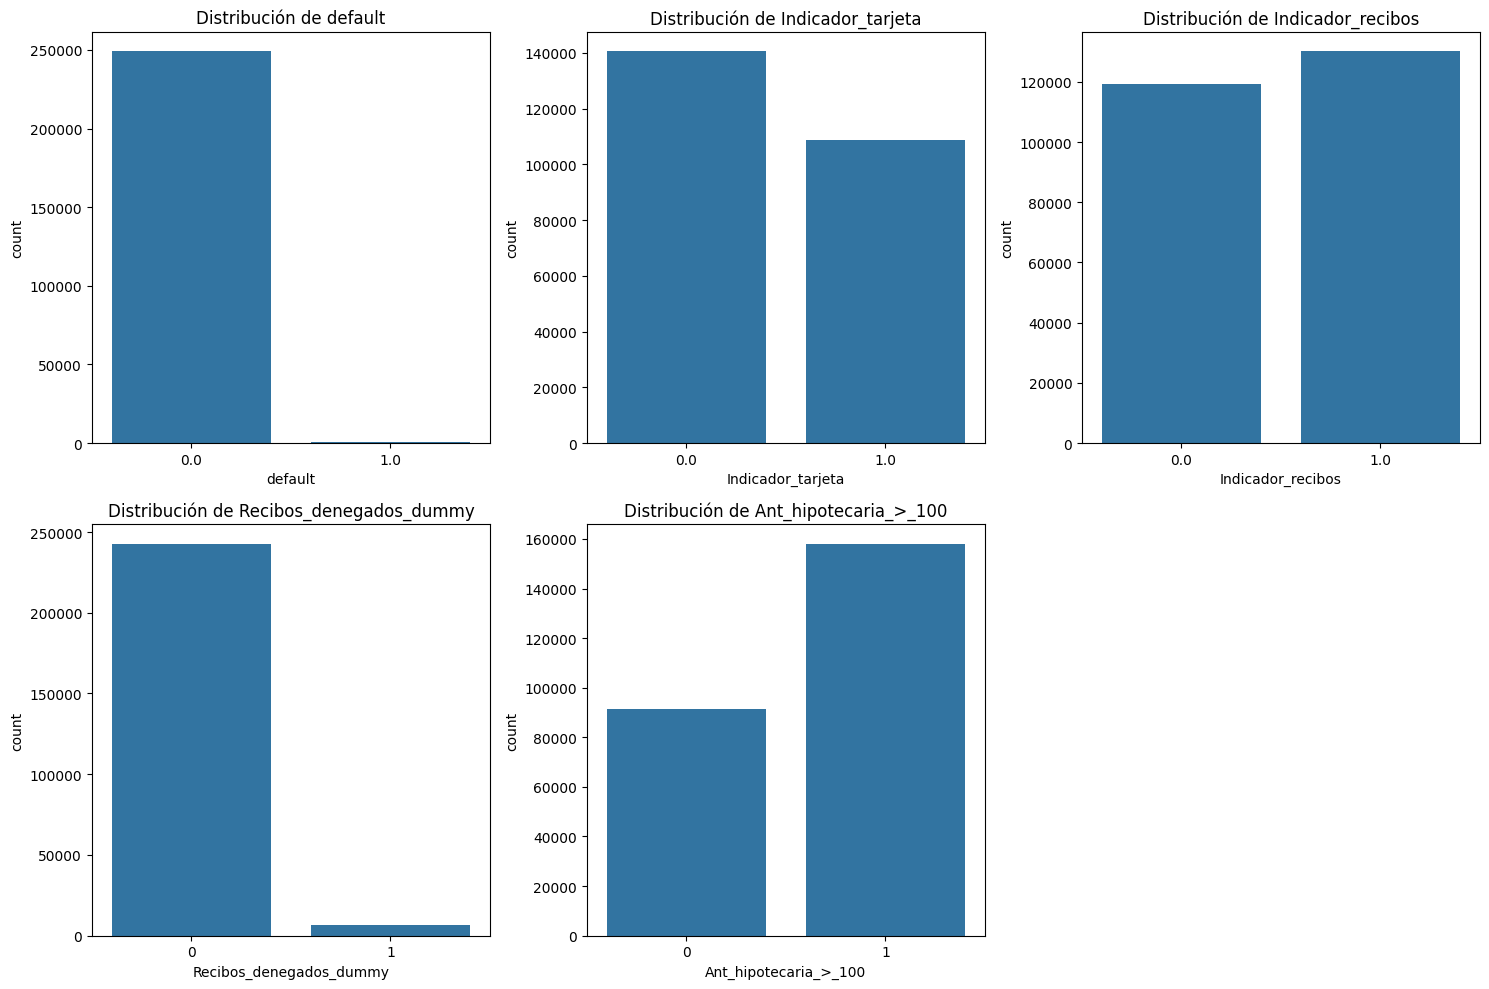

In [16]:
# Filtrar las columnas que tienen menos de 10 categorías
variables_para_graficar = [col for col in variables_categoricas if len(frecuencias_categoricas[col]) <= 10]

graficos_por_fila = 3
filas = math.ceil(len(variables_para_graficar) / graficos_por_fila)

# Crear los subplots
fig, axes = plt.subplots(filas, graficos_por_fila, figsize=(5 * graficos_por_fila, 5 * filas))

# Asegurarse de que `axes` es un arreglo bidimensional
axes = axes.reshape(-1, graficos_por_fila)

# Iterar sobre las variables y graficar
for idx, col in enumerate(variables_para_graficar):
    fila, col_fila = divmod(idx, graficos_por_fila)
    ax = axes[fila, col_fila]
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f'Distribución de {col}')

# Eliminar subplots vacíos si el número de gráficos no es múltiplo de `graficos_por_fila`
for idx in range(len(variables_para_graficar), filas * graficos_por_fila):
    fila, col_fila = divmod(idx, graficos_por_fila)
    fig.delaxes(axes[fila, col_fila])

plt.tight_layout()
plt.show()

**2. Análisis de Variables Continuas**

In [17]:
# Extraer variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns
len(variables_continuas)

52

**Visualización de la Distribución de Variables Continuas**

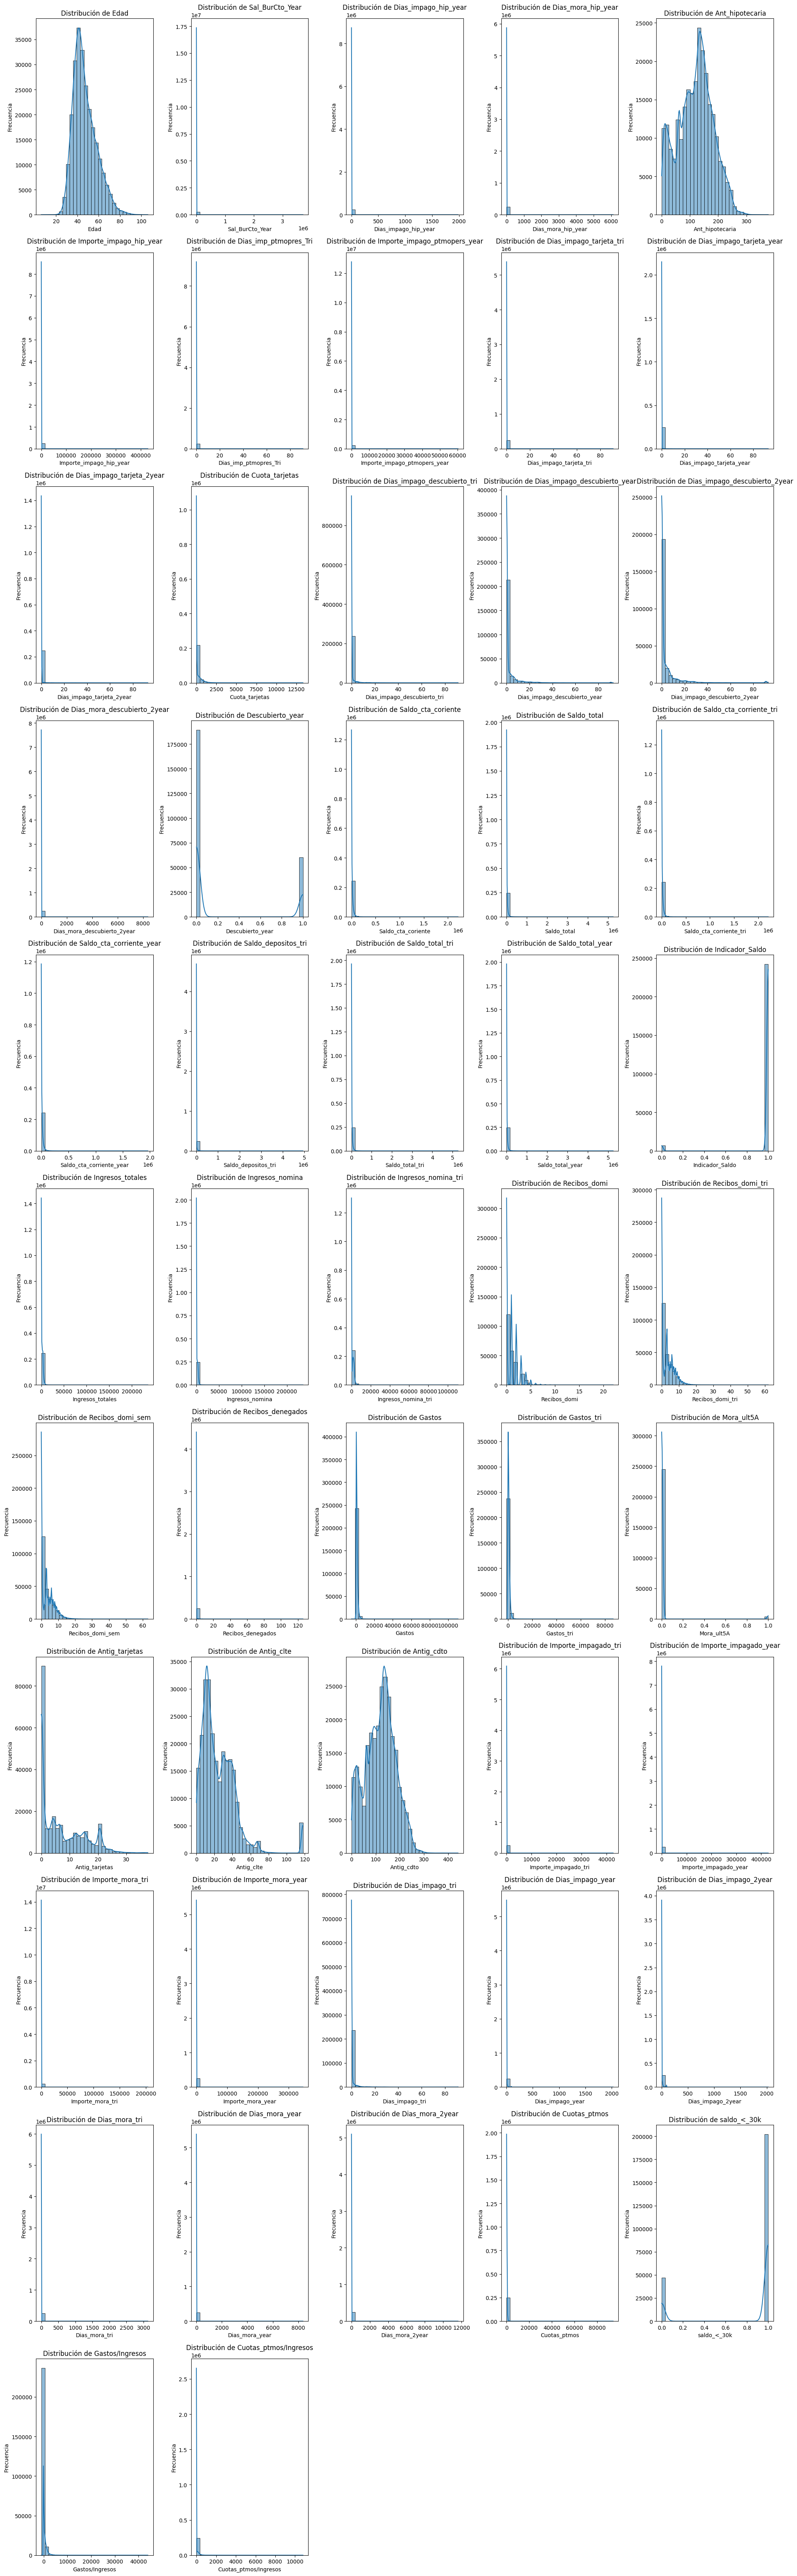

In [18]:
# Estadísticos descriptivos de las variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns

# Crear la figura y los subgráficos
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Crear los histogramas
for i, var in enumerate(variables_continuas):
    sns.histplot(df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Detección de Valores Atípicos (Outliers)**

In [19]:
# Detección de outliers mediante IQR
def detectar_outliers(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[variable] < limite_inferior) | (df[variable] > limite_superior)]

# # Número de filas y columnas para la cuadrícula
# n_cols = 5
# n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# # Crear la figura y los subgráficos
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# # Aplanar la matriz de ejes para facilitar el acceso
# axes = axes.flatten()

# Mostrar outliers y boxplots por cada variable continua
for i, var in enumerate(variables_continuas):
    outliers = detectar_outliers(df, var)
    print(f'Outliers en {var}:', outliers.shape[0])
#     sns.boxplot(data=df, x=var, ax=axes[i])
#     axes[i].set_title(f'Boxplot de {var}')
#     axes[i].set_xlabel(var)

# # Eliminar los ejes adicionales si hay menos variables que subgráficos
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Ajustar el layout para evitar solapamientos
# plt.tight_layout()
# plt.show()

Outliers en Edad: 3607
Outliers en Sal_BurCto_Year: 6512
Outliers en Dias_impago_hip_year: 22830
Outliers en Dias_mora_hip_year: 382
Outliers en Ant_hipotecaria: 199
Outliers en Importe_impago_hip_year: 22715
Outliers en Dias_imp_ptmopres_Tri: 80
Outliers en Importe_impago_ptmopers_year: 596
Outliers en Dias_impago_tarjeta_tri: 617
Outliers en Dias_impago_tarjeta_year: 2698
Outliers en Dias_impago_tarjeta_2year: 4592
Outliers en Cuota_tarjetas: 47303
Outliers en Dias_impago_descubierto_tri: 24021
Outliers en Dias_impago_descubierto_year: 60129
Outliers en Dias_impago_descubierto_2year: 30732
Outliers en Dias_mora_descubierto_2year: 618
Outliers en Descubierto_year: 60129
Outliers en Saldo_cta_coriente: 23387
Outliers en Saldo_total: 24795
Outliers en Saldo_cta_corriente_tri: 23104
Outliers en Saldo_cta_corriente_year: 22635
Outliers en Saldo_depositos_tri: 45285
Outliers en Saldo_total_tri: 24640
Outliers en Saldo_total_year: 24681
Outliers en Indicador_Saldo: 6942
Outliers en Ingresos

**Test T**

In [33]:
variables_significativas = []

# Realizar el Test T para cada variable continua
for var in variables_continuas:
    group_0 = df[df['default'] == 0][var]
    group_1 = df[df['default'] == 1][var]
    
    # Realizar el test T de Student
    t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
    
    print(f"Test T para {var}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}\n")
    
    # Si el valor p es menor a 0.05, se considera que hay una diferencia significativa
#    if p_value < 0.05:
#        print("Conclusión: Existen diferencias significativas entre las medias de las dos categorías.\n")
#        variables_significativas.append(var)
#    else:
#        print("Conclusión: No hay diferencias significativas entre las medias de las dos categorías.\n")

    if p_value < 0.05:
        variables_significativas.append(var)

# Mostrar las variables significativas
print("Variables con diferencias significativas:")
print(variables_significativas)

c:\Users\Nagore MU\.conda\envs\finanzas\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Test T para default:
T-statistic: -inf, P-value: 0.000

Test T para Edad:
T-statistic: -5.558, P-value: 0.000

Test T para Sal_BurCto_Year:
T-statistic: -2.464, P-value: 0.014

Test T para Dias_impago_hip_year:
T-statistic: -42.270, P-value: 0.000

Test T para Dias_mora_hip_year:
T-statistic: -17.155, P-value: 0.000

Test T para Ant_hipotecaria:
T-statistic: -2.474, P-value: 0.013

Test T para Importe_impago_hip_year:
T-statistic: -4.440, P-value: 0.000

Test T para Dias_imp_ptmopres_Tri:
T-statistic: 0.219, P-value: 0.826

Test T para Importe_impago_ptmopers_year:
T-statistic: -0.468, P-value: 0.640

Test T para Dias_impago_tarjeta_tri:
T-statistic: -20.189, P-value: 0.000

Test T para Dias_impago_tarjeta_year:
T-statistic: -18.079, P-value: 0.000

Test T para Dias_impago_tarjeta_2year:
T-statistic: -14.708, P-value: 0.000

Test T para Cuota_tarjetas:
T-statistic: 6.468, P-value: 0.000

Test T para Dias_impago_descubierto_tri:
T-statistic: -51.663, P-value: 0.000

Test T para Dias_imp

### **3. Análisis Bivariante**

**Correlación de todas las variables**

In [21]:
df['default'] = pd.to_numeric(df['default'], errors='coerce')

# Calcular la matriz de correlaciones
umbral = 0.7 
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral
filtered_corr_matrix = corr_matrix.where(np.abs(corr_matrix) > umbral)

# Eliminar la diagonal para que no se muestre
filtered_corr_matrix = filtered_corr_matrix.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral
filtered_corr_matrix.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix = filtered_corr_matrix[filtered_corr_matrix['Variable_1'] != filtered_corr_matrix['Variable_2']]

pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_total_tri,Saldo_total,0.994641
1,Saldo_total,Saldo_total_tri,0.994641
2,Ant_hipotecaria,Antig_cdto,0.993897
3,Antig_cdto,Ant_hipotecaria,0.993897
4,Importe_impago_hip_year,Importe_impagado_year,0.989843
5,Importe_impagado_year,Importe_impago_hip_year,0.989843
6,Saldo_cta_corriente_tri,Saldo_cta_coriente,0.984173
7,Saldo_cta_coriente,Saldo_cta_corriente_tri,0.984173
8,Saldo_total_year,Saldo_total_tri,0.982182
9,Saldo_total_tri,Saldo_total_year,0.982182


**Correlación con las variables consideradas de interés**

In [22]:
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

df_filtered = df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()
umbral = 0.3
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral
filtered_corr_matrix2 = correlation_matrix.where(np.abs(correlation_matrix) > umbral)

# Eliminar la diagonal para que no se muestre
filtered_corr_matrix2 = filtered_corr_matrix2.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral
filtered_corr_matrix2.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix2 = filtered_corr_matrix2[filtered_corr_matrix2['Variable_1'] != filtered_corr_matrix2['Variable_2']]

pd.set_option('display.max_rows', None)
filtered_corr_matrix2.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_cta_corriente_year,Saldo_total,0.684352
1,Saldo_total,Saldo_cta_corriente_year,0.684352
2,Dias_impago_descubierto_year,Dias_impago_hip_year,0.323623
3,Dias_impago_hip_year,Dias_impago_descubierto_year,0.323623


**Diagrama de pareto**

C:\Users\Nagore MU\AppData\Local\Temp\ipykernel_8640\3942738229.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Variable', y='Importancia', data=pareto_df, palette='coolwarm')


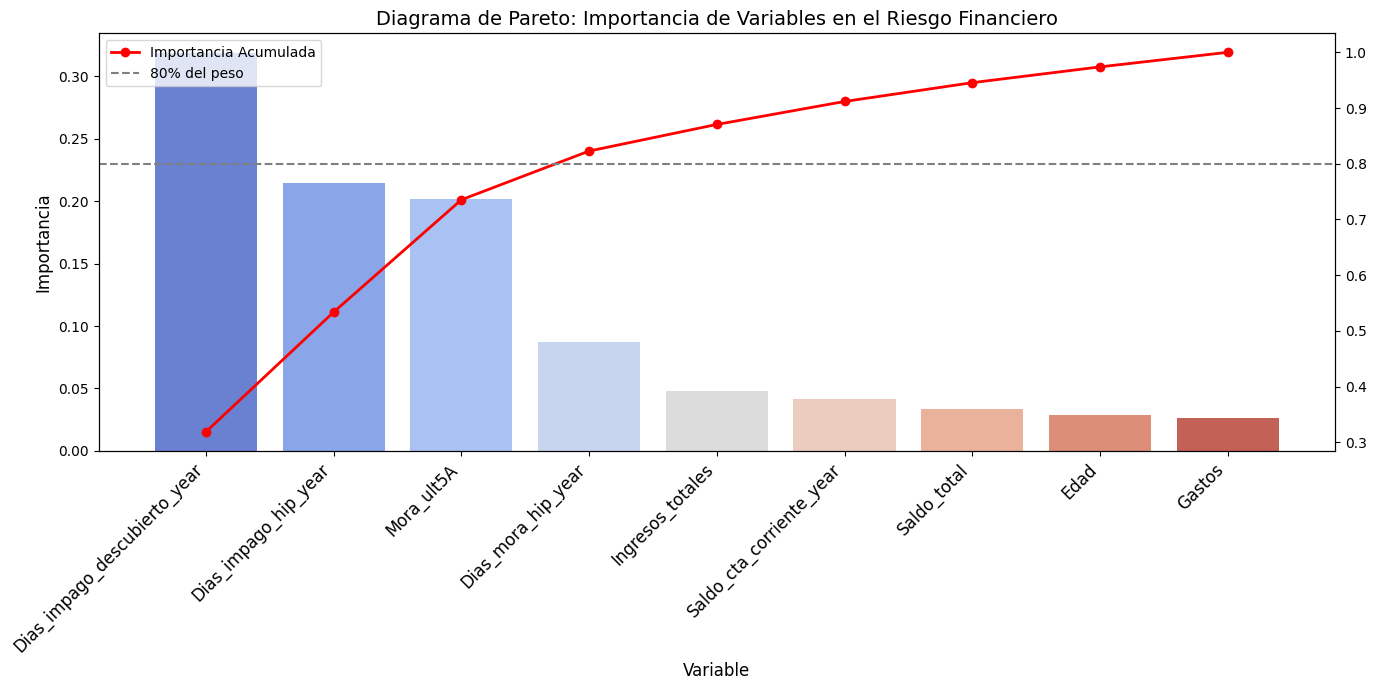

In [23]:
variables = [var for var in variables_interes if var != 'default']

# Calcular importancia
importances = []
for var in variables:
    if is_numeric_dtype(df[var]):
        correlation = abs(df[var].corr(df['default']))
    else:
        mutual_info = mutual_info_classif(df[[var]], df['default'], discrete_features=True)
        correlation = mutual_info[0]
    importances.append((var, correlation))

# Normalizar importancias
importances = [(var, imp / sum(imp for _, imp in importances)) for var, imp in importances]

# Ordenar y convertir a DataFrame
importances = sorted(importances, key=lambda x: x[1], reverse=True)
pareto_df = pd.DataFrame(importances, columns=['Variable', 'Importancia'])
pareto_df['Importancia_Acumulada'] = pareto_df['Importancia'].cumsum()

# Graficar
plt.figure(figsize=(14, 7))
sns.barplot(x='Variable', y='Importancia', data=pareto_df, palette='coolwarm')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Importancia', fontsize=12)
plt.xlabel('Variable', fontsize=12)
plt.title('Diagrama de Pareto: Importancia de Variables en el Riesgo Financiero', fontsize=14)
plt.twinx()
plt.plot(pareto_df['Importancia_Acumulada'], color='r', marker='o', linewidth=2, label='Importancia Acumulada')
plt.axhline(0.8, color='gray', linestyle='--', label='80% del peso')
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()


**Correlación de Pearson**

Correlaciones significativas con 'default':
default                          1.000000
Dias_impago_descubierto_year     0.124999
Dias_impago_descubierto_2year    0.119540
Dias_impago_tri                  0.115121
Dias_impago_2year                0.112001
Dias_impago_year                 0.109373
Dias_impago_descubierto_tri      0.102896
Name: default, dtype: float64


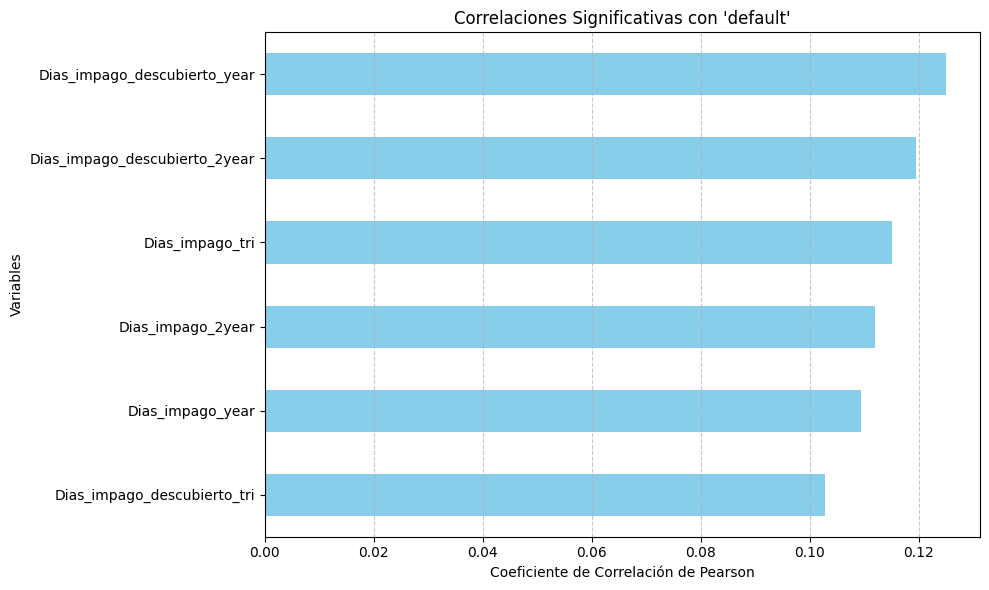

In [24]:
# Convertir la columna 'default' a tipo numérico para calcular la correlación
df['default'] = pd.to_numeric(df['default'], errors='coerce')

# Seleccionar solo las variables continuas y la columna 'default'
variables_continuas = df.select_dtypes(include=['int', 'float']).columns.tolist()
if 'default' not in variables_continuas:
    variables_continuas.append('default')

# Calcular la matriz de correlación
correlation_matrix = df[variables_continuas].corr(method='pearson')

# Obtener las correlaciones con respecto a 'default'
correlaciones_default = correlation_matrix['default'].sort_values(ascending=False)

# Filtrar correlaciones significativas (por ejemplo, mayor a 0.1 o menor a -0.1)
umbral = 0.1  # Ajusta el umbral según sea necesario
correlaciones_significativas = correlaciones_default[abs(correlaciones_default) > umbral]

# Mostrar las correlaciones significativas
print("Correlaciones significativas con 'default':")
print(correlaciones_significativas)

# Graficar las correlaciones significativas
plt.figure(figsize=(10, 6))
correlaciones_significativas.drop('default').sort_values().plot(kind='barh', color='skyblue')
plt.title("Correlaciones Significativas con 'default'")
plt.xlabel("Coeficiente de Correlación de Pearson")
plt.ylabel("Variables")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Chi-cuadrado**

In [25]:
chi2_results = {}

# Filtrar las variables categóricas para que no incluyan 'default' ni 'cliente'
variables_categoricas_filtradas = [col for col in variables_categoricas if col not in ['default', 'Cliente']]

# Calcular el chi-cuadrado
for col in variables_categoricas_filtradas:
    contingency_table = pd.crosstab(df[col], df['default'])
    chi2, p, _, _ = chi2_contingency(contingency_table, correction=False)
    chi2_results[col] = {'Chi2': chi2, 'p_value': p}

# Convertir los resultados en un DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)

print("Resultados del test Chi-cuadrado:")
print(chi2_df)

Resultados del test Chi-cuadrado:
                               Chi2       p_value
Recibos_denegados_dummy  258.707930  3.282156e-58
Indicador_recibos        119.321915  8.904077e-28
Indicador_tarjeta         97.506506  5.367962e-23
Ant_hipotecaria_>_100     13.795366  2.038384e-04


### **4. Construcción del Modelo de Clasificación**

**Filtrar por columnas seleccionadas tras el análisis**

In [26]:
# Seleccionar las columnas de interés
columnas_interes = [
    'Dias_impago_descubierto_year',
    'Dias_impago_hip_year',
    'Indicador_recibos',
    'Indicador_tarjeta',
    'Mora_ult5A',
    'Recibos_denegados_dummy',
    'Edad',
    'Sal_BurCto_Year',
    'default'  # Variable objetivo
]

# Filtrar el dataset
df_filtered = df[columnas_interes]
df_filtered.dtypes

Dias_impago_descubierto_year    float64
Dias_impago_hip_year            float64
Indicador_recibos                object
Indicador_tarjeta                object
Mora_ult5A                      float64
Recibos_denegados_dummy          object
Edad                            float64
Sal_BurCto_Year                 float64
default                         float64
dtype: object

**Balanceo y división en train y test**

In [27]:
# Definir las variables predictoras y la variable objetivo
X = df_filtered.drop('default', axis=1)
y = df_filtered ['default']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train_og, X_test, y_train_og, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
y_train_og = y_train_og.astype(int)
y_test = y_test.astype(int)

minority_class_count = sum(y_train_og == 1)  # Asumiendo que la clase minoritaria es 1
majority_class_count = 1 * minority_class_count  # La clase mayoritaria será 5 veces la minoritaria
sampling_strategy = {0: majority_class_count, 1: minority_class_count}  # Ajustar según las etiquetas de tus clases

# Balancear los datos
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train, y_train = undersampler.fit_resample(X_train_og, y_train_og)

# Ver la distribución de las clases después del undersampling
print("Distribución original en el conjunto de entrenamiento:")
print(y_train_og.value_counts())
print("\nDistribución después del undersampling:")
print(y_train.value_counts())

Distribución original en el conjunto de entrenamiento:
default
0    174331
1       272
Name: count, dtype: int64

Distribución después del undersampling:
default
0    272
1    272
Name: count, dtype: int64


##### **A) Modelo Regresión Logística y su evaluación**

In [28]:
# Entrenamos el modelo
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Predicciones sobre el conjunto de validación
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]
y_pred = log_reg_model.predict(X_test)

c:\Users\Nagore MU\.conda\envs\finanzas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Curva ROC y AUC**

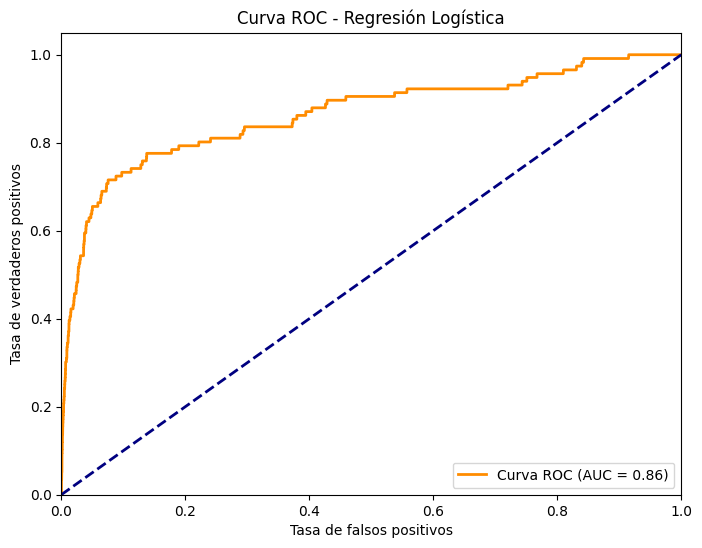

In [29]:
# Cálculo de la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

**Matriz de confusión**

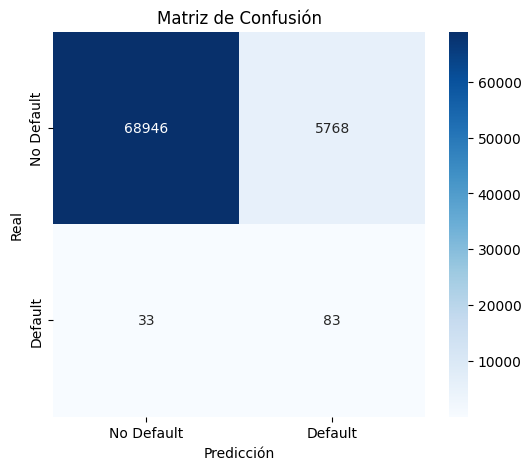

In [30]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [31]:
# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")

Accuracy del modelo: 0.9225


**Test de Wald**

In [42]:
# Obtener coeficientes del modelo
coefficients = log_reg_model.coef_[0]

# Calcular la matriz de covarianza de los coeficientes
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
cov_matrix = np.linalg.inv(np.dot(X_train_intercept.T, X_train_intercept))

# Error estándar de los coeficientes
standard_errors = np.sqrt(np.diag(cov_matrix))

# Calcular el estadístico z y p-valores
z_scores = coefficients / standard_errors[1:]  # Omitir el intercepto
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

wald_test_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient': [log_reg_model.intercept_[0]] + list(coefficients),
    'Std. Error': [np.nan] + list(standard_errors[1:]),
    'z-score': [np.nan] + list(z_scores),
    'p-value': [np.nan] + list(p_values)
})

print(wald_test_results)

                        Feature  Coefficient  Std. Error    z-score  \
0                     Intercept    -0.456974         NaN        NaN   
1  Dias_impago_descubierto_year     0.065583    0.002079  31.552176   
2          Dias_impago_hip_year     0.056194    0.002153  26.101351   
3             Indicador_recibos    -0.755270    0.098023  -7.704994   
4             Indicador_tarjeta    -0.587145    0.102160  -5.747299   
5                    Mora_ult5A     0.441516    0.139366   3.168034   
6       Recibos_denegados_dummy     0.209185    0.154052   1.357890   
7                          Edad     0.001257    0.003687   0.341043   
8               Sal_BurCto_Year     0.000005    0.000006   0.862141   

        p-value  
0           NaN  
1  0.000000e+00  
2  0.000000e+00  
3  1.310063e-14  
4  9.068040e-09  
5  1.534734e-03  
6  1.744985e-01  
7  7.330714e-01  
8  3.886099e-01  


**Importancia de las variables en el modelo**

In [34]:
# Obtenemos los coeficientes del modelo
coefficients = log_reg_model.coef_[0]
importance_percentage = 100 * (np.abs(coefficients) / np.sum(np.abs(coefficients)))

# Crear un DataFrame para mostrar resultados
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature_{i}" for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": importance_percentage
}).sort_values(by="Importance (%)", ascending=False)

print(importance_df)

                        Feature  Importance (%)
2             Indicador_recibos       35.690672
3             Indicador_tarjeta       27.745821
4                    Mora_ult5A       20.864049
5       Recibos_denegados_dummy        9.885141
0  Dias_impago_descubierto_year        3.099154
1          Dias_impago_hip_year        2.655493
6                          Edad        0.059420
7               Sal_BurCto_Year        0.000251


##### **B) Modelo Black box y su evaluación**

In [35]:
# Instanciar el LabelEncoder
le = LabelEncoder()

# Conversiones en variables necesarias para el modelo
X_train['Indicador_recibos'] = le.fit_transform(X_train['Indicador_recibos'])
X_train['Indicador_tarjeta'] = le.fit_transform(X_train['Indicador_tarjeta'])
X_train['Recibos_denegados_dummy'] = le.fit_transform(X_train['Recibos_denegados_dummy'])

X_test['Indicador_recibos'] = le.transform(X_test['Indicador_recibos'])
X_test['Indicador_tarjeta'] = le.transform(X_test['Indicador_tarjeta'])
X_test['Recibos_denegados_dummy'] = le.transform(X_test['Recibos_denegados_dummy'])

In [36]:
# Convertir a DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Entrenar el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Predicciones
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

**Curva ROC**

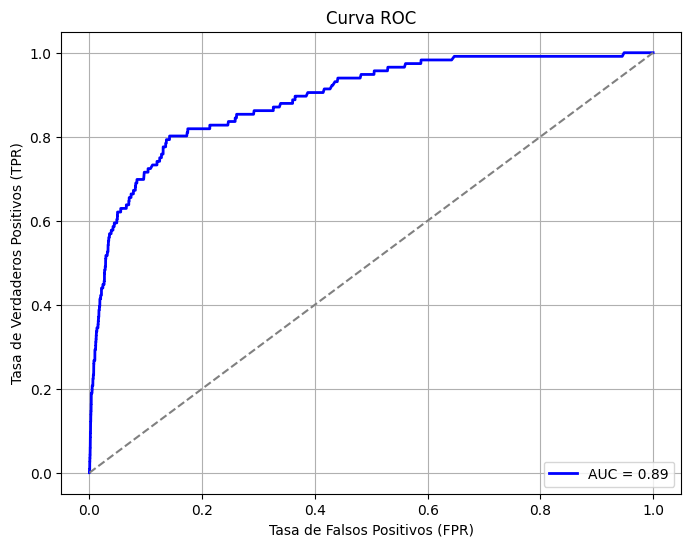

In [37]:
# Calcular la curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Crear el gráfico de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Matriz de confusión**

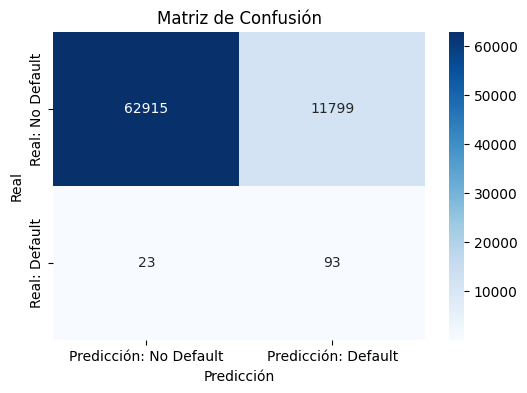

In [38]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción: No Default', 'Predicción: Default'], yticklabels=['Real: No Default', 'Real: Default'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [39]:
# Sacar accuracy del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.842015234531605


**Importancia de las variables en el modelo**

                        Feature  Importance  Importance (%)
6                          Edad       698.0       50.543085
0  Dias_impago_descubierto_year       290.0       20.999276
1          Dias_impago_hip_year       127.0        9.196235
2             Indicador_recibos        67.0        4.851557
3             Indicador_tarjeta        63.0        4.561912
7               Sal_BurCto_Year        63.0        4.561912
4                    Mora_ult5A        45.0        3.258508
5       Recibos_denegados_dummy        28.0        2.027516


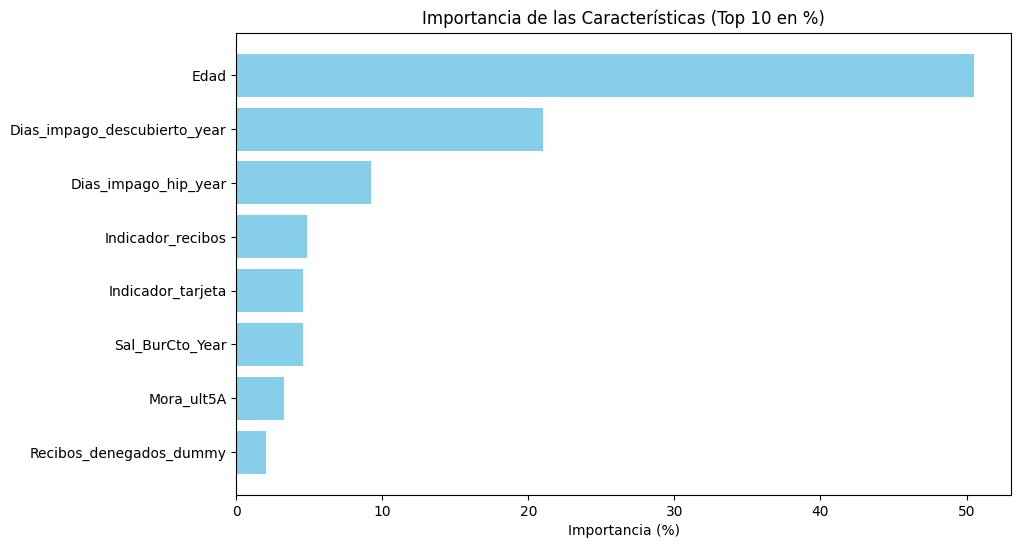

In [40]:
# Importancia de las características
feature_importance = model.get_score(importance_type='weight')

# Convertir a un DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values(by="Importance", ascending=False)

# Normalizar las importancias en porcentaje
importance_df['Importance (%)'] = 100 * (importance_df['Importance'] / importance_df['Importance'].sum())
print(importance_df)

# Visualización de las importancias en porcentaje
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance (%)'][:10], color='skyblue')
plt.xlabel('Importancia (%)')
plt.title("Importancia de las Características (Top 10 en %)")
plt.gca().invert_yaxis()  # Invertir el eje Y para que el top esté arriba
plt.show()

#### **Aparte: Gráfico para ver el valor óptimo del undersampling**

<Figure size 1200x700 with 0 Axes>

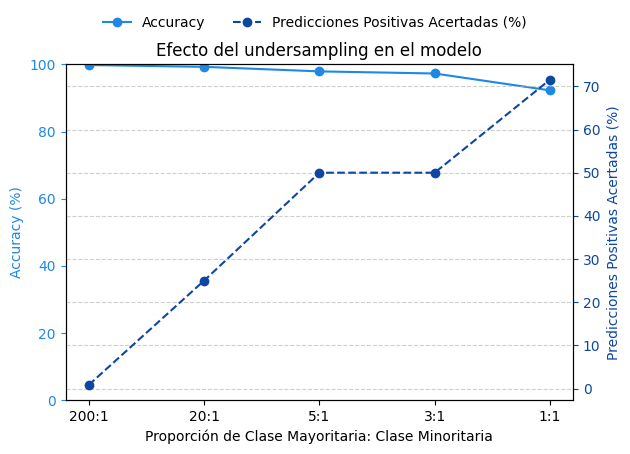

In [41]:
# Ocultar warnings
warnings.filterwarnings('ignore')

# Inicializar listas para resultados
accuracies = []
predicciones_positivas_acertadas = []

# Proporciones de undersampling
for i in [200, 20, 5, 3, 1]:
    # Ajustar conteo de clases
    minority_class_count = sum(y_train_og == 1)  # Clase minoritaria asumida como 1
    majority_class_count = i * minority_class_count  # Proporción deseada

    sampling_strategy = {0: majority_class_count, 1: minority_class_count}

    # Aplicar undersampling
    undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train, y_train = undersampler.fit_resample(X_train_og, y_train_og)

    # Entrenar modelo
    log_reg_model = LogisticRegression(random_state=42)
    log_reg_model.fit(X_train, y_train)

    # Predicciones
    y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]
    y_pred = log_reg_model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)
    n_predicciones_positivas_acertadas = cm[1, 1] / sum(cm[1, :]) * 100

    accuracies.append(accuracy)
    predicciones_positivas_acertadas.append(n_predicciones_positivas_acertadas)

# Visualización
plt.figure(figsize=(12, 7))

# Crear eje principal
fig, ax1 = plt.subplots()

# Eje principal: Accuracy
ax1.set_xlabel('Proporción de Clase Mayoritaria: Clase Minoritaria')
ax1.set_ylabel('Accuracy (%)', color='#1E88E5')  # Azul principal
accuracy_line, = ax1.plot(['200:1', '20:1', '5:1', '3:1', '1:1'], accuracies, 
                          marker='o', linestyle='-', color='#1E88E5', label='Accuracy')
ax1.tick_params(axis='y', colors='#1E88E5')
ax1.set_ylim(0, 100)

# Eje secundario: Predicciones positivas acertadas
ax2 = ax1.twinx()
ax2.set_ylabel('Predicciones Positivas Acertadas (%)', color='#0D47A1')  # Azul oscuro
positive_preds_line, = ax2.plot(['200:1', '20:1', '5:1', '3:1', '1:1'], predicciones_positivas_acertadas, 
                                marker='o', linestyle='--', color='#0D47A1', label='Predicciones Positivas Acertadas (%)')
ax2.tick_params(axis='y', colors='#0D47A1')

# Añadir título y leyenda
plt.title('Efecto del undersampling en el modelo')

# Crear leyenda combinada
fig.legend([accuracy_line, positive_preds_line], ['Accuracy', 'Predicciones Positivas Acertadas (%)'], 
           loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.9])
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar gráfico
plt.show()